In [2]:
# Import nilearn and numpy
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
from nilearn import signal
from scipy import stats
import nibabel as nib
import glob
import os
sk = 3
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# install nsdcode by cloning the repository and following the instructions:
# https://github.com/cvnlab/nsdcode/
from nsdcode.nsd_mapdata import NSDmapdata
from nsdcode.nsd_datalocation import nsd_datalocation
from nsdcode.nsd_output import nsd_write_fs
from nsdcode.utils import makeimagestack

In [4]:
# List all paths
basedir ='/scratch/groups/jyeatman/NSD/ppdata/'
fsdir = '/scratch/groups/jyeatman/NSD/nsddata/freesurfer/'
analysisdir = os.path.dirname(os.path.dirname((basedir))) + '/analysis/'
outputdir = analysisdir + 'newlabels/'
nsd_path = '/scratch/groups/jyeatman/NSD/'
nsd = NSDmapdata(nsd_path)

In [52]:
# Set parameters
clobber = False
hemi='lh'
droptp = [0,1,2,3,4,5]
subs = ['subj01','subj02','subj03','subj04','subj05','subj06','subj07','subj08']
roi_names = ['vwfa1','vwfa2']
roi_labels = [2,3]
# new labels
new_labels = True
if new_labels:
    roi_names = ['vwfa1','vwfa2','IFSwords','IPSwords']


# map volume to surface space
sourcespace = 'func1pt8'
targetspace = hemi+'.layerB2'
interpmethod = 'cubic'

# for plotting
if hemi == 'lh':
    h = 'left'
elif hemi == 'rh':
    h = 'right'
    # For plotting
bg = 'curv' # options are: 'sulc','curv'

In [54]:
subs = subs[0:5]
subs

['subj01', 'subj02', 'subj03', 'subj04', 'subj05']

In [50]:
runTtest = True
plotView = True
saveFigs = True

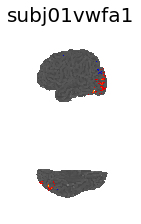

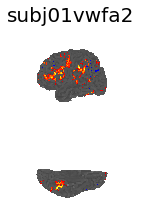

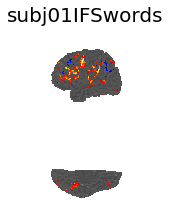

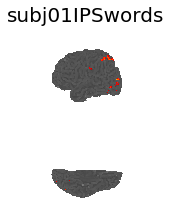

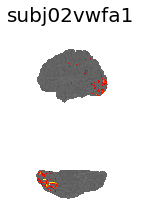

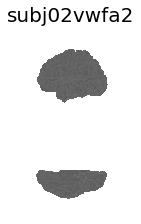

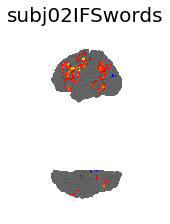

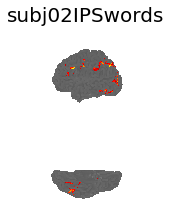

Error in callback <function flush_figures at 0x7efcae46f160> (for post_execute):


KeyboardInterrupt: 

In [55]:
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    bolddir = basedir + sub + '/func1pt8mm/timeseries/'
    motiondir = basedir + sub + '/func1pt8mm/motion/'
    
    lhsurf = surface.load_surf_mesh(fssub + '/surf/'+hemi+'.white')
    labels = surface.load_surf_data(fssub + '/label/'+hemi+'.floc-words.mgz')
    if bg == 'curv':
        bg_map = surface.load_surf_data(fssub + '/surf/'+hemi+'.curv')
        # TEST visualisation with sulcul depth instead of curvature data
    elif bg == 'sulc':
        bg_map = surface.load_surf_data(fssub + '/surf/'+hemi+'.sulc')
    
    
    runs = glob.glob(bolddir + '/timeseries*nii.gz')
    runs.sort()
    sub_filepath = outputdir + sub + '_' + str(len(runs)) + 'runs_' + hemi + '.npy'
    roi_zmap = np.load(sub_filepath)
    
    
    for rr,roi in enumerate(roi_names):
        outputfile = sub + '_MeanZ_' + roi + '_' + str(len(runs)) + 'runs_' + hemi + '_' + bg
        mean_map = np.nanmean(roi_zmap[:,:,rr],axis=1)
        
        # Create interactive plot  
        if plotView:
            view = plotting.view_surf(lhsurf, surf_map=mean_map,
            threshold = 0.2, vmax=0.7, colorbar=True,hemi=h,
            bg_map=bg_map,title=outputfile)
            view.save_as_html(outputdir + outputfile+'.html')
        
        # Create figure
        if saveFigs:

#             fig, axes = plt.subplots(2,1,figsize=(5,3),subplot_kw={'projection': '3d'},constrained_layout=True)
#             plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
#             hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=False,axes=axes[0],
#             bg_map=bg_map,title=None, output_file = None)

#             plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
#             hemi=h, threshold = .2, vmax=0.7, view='ventral', colorbar=False,axes=axes[1],
#             bg_map=bg_map,title=None, output_file = None)
            
#             fig.suptitle(sub + roi,fontsize=20)
#             fig.savefig(outputdir + outputfile+'.png')

            plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
            hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=False,
            bg_map=bg_map,title=None, output_file = outputdir + outputfile+'lat.png')

            plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
            hemi=h, threshold = .2, vmax=0.7, view='ventral', colorbar=False,
            bg_map=bg_map,title=None, output_file = outputdir + outputfile+'ven.png')

        # Save individual maps as .gii files so we can load them in Freeview

            targetFile = outputdir + outputfile + '.curv'
            if not os.path.exists(targetFile):
                nib.freesurfer.io.write_morph_data(targetFile,mean_map)
       
  
    # ROI indices to compare with t-test
    if runTtest:
        roi1=0
        roi2=1

        ttest_map = stats.ttest_rel(roi_zmap[:,:,roi1],roi_zmap[:,:,roi2],nan_policy='omit',axis=1)
        ttest_img_file = outputdir + sub + '_T-test_' + roi_names[roi1] + '_' + roi_names[roi2] + '_' + str(len(runs)) + 'runs_' + hemi + '_' + bg

        # Plot
        fig =plotting.plot_surf_stat_map(lhsurf, stat_map=ttest_map.statistic, 
        hemi=h, threshold = 4, vmax=12, view='lateral', colorbar=True,
        bg_map=bg_map,title=sub + '_' + str(len(runs)) + 'runs', output_file = ttest_img_file + '_lat.png')
        print()
        fig =plotting.plot_surf_stat_map(lhsurf, stat_map=ttest_map.statistic, 
        hemi=h, threshold = 4, vmax=12, view='ventral', colorbar=True,
        bg_map=bg_map,title=sub + '_' + str(len(runs)) + 'runs', output_file = ttest_img_file + '_ven.png')
        print()

        # interactive plot    
        view = plotting.view_surf(lhsurf, surf_map=ttest_map.statistic,
        threshold = 4, vmax=12, colorbar=True,
        bg_map=bg_map,title='t-test')
        view.save_as_html(ttest_img_file+'.html')

## Transform results from fsnative to fsaverage

In [107]:
# we want to transform data from native space 
# (lh.white is the same as B2layer for this purpose, see https://cvnlab.slite.page/p/QtQPzl1xnH/FAQ)
# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage',data_dir = '/home/groups/jyeatman/software')
fsaverage_white = surface.load_surf_data(fsaverage['white_' + h])

fsaverage_data = np.zeros([fsaverage_white[0].shape[0],len(subs),len(roi_names)])
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    sub_filepath = outputdir + sub + '_' + str(len(runs)) + 'runs_' + hemi + '.npy'
    roi_zmap = np.load(sub_filepath) 
    for rr,roi in enumerate(roi_names):
        sourcedata = roi_zmap[:,:,rr]
        subjix = int(sub[-1])
        print('Running on ' + sub + ', ' + roi)
        print('Original shape:')
        print(sourcedata.shape)
        
        roi_map_fsaverage = nsd.fit(subjix,
        'lh.white',
        'fsaverage',
        sourcedata,
        interptype=None,
        badval=0,
        outputfile=None,
        fsdir=fsdir)
        print('Transformed shape:')
        print(roi_map_fsaverage.shape)
        
        fsaverage_data[:,s,rr]=np.nanmean(roi_map_fsaverage,axis=1)

Running on subj01, vwfa1
Original shape:
(227021, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj01, vwfa2
Original shape:
(227021, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj01, IFSwords
Original shape:
(227021, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj01, IPSwords
Original shape:
(227021, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, vwfa1
Original shape:
(239633, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, vwfa2
Original shape:
(239633, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, IFSwords
Original shape:
(239633, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj02, IPSwords
Original shape:
(239633, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj03, vwfa1
Original shape:
(240830, 20)
data array passed
Transformed shape:
(163842, 20)
Running on subj03, vwfa2
Original shape:
(240830, 20

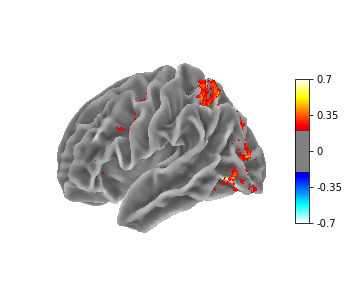

In [112]:
plotting.plot_surf_stat_map(fsaverage['white_' + h], stat_map=fsaverage_data[:,0,3],
hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=True,
bg_map=fsaverage['curv_' + h],title=None, output_file = None)
print()

In [111]:
plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map,
hemi=h, threshold = .2, vmax=0.7, view='lateral', colorbar=False,
bg_map=bg_map,title=None, output_file = None)


'subj05'

## Testing different backgrounds

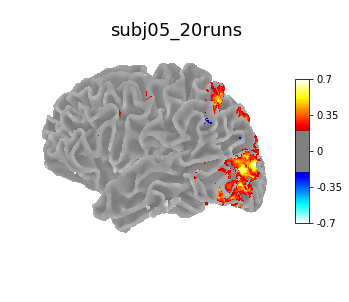

In [21]:
fig =plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map, 
hemi=h, threshold = 0.2, vmax=0.7, view='lateral', colorbar=True,
bg_map=curv,title=sub + '_' + str(len(runs)) + 'runs', output_file =None)
print()

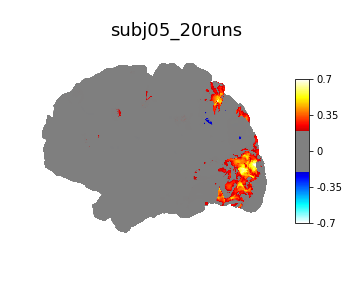

In [22]:
fig =plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map, 
hemi=h, threshold = 0.2, vmax=0.7, view='lateral', colorbar=True,
bg_map=None,title=sub + '_' + str(len(runs)) + 'runs', output_file =None)
print()

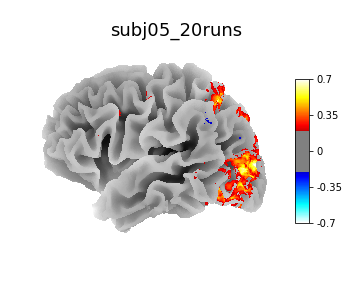

In [24]:
fig =plotting.plot_surf_stat_map(lhsurf, stat_map=mean_map, 
hemi=h, threshold = 0.2, vmax=0.7, view='lateral', colorbar=True,
bg_map=sulc,title=sub + '_' + str(len(runs)) + 'runs', output_file =None)
print()

(array([5.00000e+00, 1.00000e+00, 3.00000e+00, 8.00000e+00, 2.60000e+01,
        2.35000e+02, 1.09727e+05, 1.16920e+05, 8.10000e+01, 1.50000e+01]),
 array([-6.2897396e+00, -5.3913469e+00, -4.4929538e+00, -3.5945611e+00,
        -2.6961682e+00, -1.7977753e+00, -8.9938241e-01, -9.8953245e-04,
         8.9740336e-01,  1.7957962e+00,  2.6941891e+00], dtype=float32),
 <BarContainer object of 10 artists>)

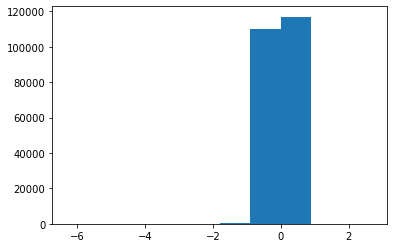

In [11]:
plt.hist(curv)

In [12]:
curv4 = surface.load_surf_data(fsdir + 'subj04' + '/surf/'+hemi+'.curv')

In [14]:
np.unique(curv4)

array([-3.8630211, -3.6134186, -3.5834572, ..., 35.416782 , 38.187855 ,
       38.498875 ], dtype=float32)